In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

from sklearn import *
from lightgbm import LGBMRegressor

/Users/amane/.pyenv/versions/3.6.1/envs/compe/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/amane/.pyenv/versions/3.6.1/envs/compe/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/amane/.pyenv/versions/3.6.1/envs/compe/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into w

パラメータ

In [54]:
log1p_beforehand = True
drop_reservation = True
target_encode = False
sample_weight = False

特徴量の作成

In [154]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

data = {
    'tra': pd.read_csv('../input/air_visit_data.csv'),
    'as': pd.read_csv('../input/air_store_info.csv'),
    'hs': pd.read_csv('../input/hpg_store_info.csv'),
    'ar': pd.read_csv('../input/air_reserve.csv'),
    'hr': pd.read_csv('../input/hpg_reserve.csv'),
    'id': pd.read_csv('../input/store_id_relation.csv'),
    'tes': pd.read_csv('../input/sample_submission.csv'),
    'hol': pd.read_csv('../input/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

if log1p_beforehand:
    data['tra']['visitors'] = np.log1p(data['tra']['visitors'])

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 'reserve_visitors':'rv2'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

train = train.fillna(-1)
test = test.fillna(-1)

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

In [159]:
val_id = ((train.year == 2017) & (train.month >= 4))
trn_id = ~val_id
print('val ratio:', f'{len(train.loc[val_id])/len(train):.2%}')

val ratio: 6.26%


In [155]:
def target_encode(col, from_date='2017-01-01'):
    global train, test
    ref = train.loc[(~val_id)&(pd.to_datetime(train.visit_date) >= pd.to_datetime(from_date))].groupby(col)['visitors'].mean().to_frame(name=col+'_target')
    train = pd.merge(left=train, right=ref, left_on=col, right_index=True, how='left')
    ref = train.loc[(pd.to_datetime(train.visit_date) >= pd.to_datetime(from_date))].groupby(col)['visitors'].mean().to_frame(name=col+'_target')
    test = pd.merge(left=test, right=ref, left_on=col, right_index=True, how='left')

In [156]:
if target_encode:
    target_encode('air_store_id')
    target_encode('air_genre_name')
    target_encode('air_area_name')

In [157]:
train = train.loc[:, train.max() != 0]

In [158]:
holiday = pd.concat([train, test]).groupby('visit_date')['holiday_flg'].mean()
holiday_rolling = holiday.rolling(window=7, center=True, min_periods=1).sum().to_frame('holiday_sum')
train = pd.merge(left=train, right=holiday_rolling, left_on='visit_date', right_index=True, how='left')
test = pd.merge(left=test, right=holiday_rolling, left_on='visit_date', right_index=True, how='left')

In [163]:
col = [c for c in train if c not in ['id', 'day_of_week', 'air_store_id2', 'air_store_id', 'air_area_name', 'air_genre_name', 'visit_date','visitors']]
if drop_reservation:
    col = [c for c in col if c not in ['rs1_x', 'rv1_x', 'rs2_x', 'rv2_x',
                                         'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 
                                         'total_reserv_sum','total_reserv_mean', 'total_reserv_dt_diff_mean']]

In [164]:
if not log1p_beforehand:
    train['visitors'] = np.log1p(train['visitors'])
X_trn = train.loc[~val_id, col]
y_trn = train.loc[~val_id, 'visitors'].values
X_val = train.loc[val_id, col]
y_val = train.loc[val_id, 'visitors'].values
X_all = train[col]
y_all = train['visitors'].values
X_tst = test[col]

In [212]:
params = {'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'min_child_samples': 30,
 'n_estimators': 500,
 'num_leaves': 60,
 'random_state': 77,
 'subsample': 0.9}
# params = {'colsample_bytree': .9, 'learning_rate': 0.05, 
#  'min_child_samples': 20, 'n_estimators': 500, 'num_leaves': 60, 'random_state': 77, 'subsample': .9}
lgb = LGBMRegressor(**params)

In [213]:
weight = (1/y_trn) if sample_weight else None
lgb.fit(X_trn, y_trn, sample_weight=weight)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       learning_rate=0.05, max_depth=-1, min_child_samples=30,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
       n_jobs=-1, num_leaves=60, objective=None, random_state=77,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
       subsample_for_bin=200000, subsample_freq=1)

In [214]:
print(f'train: {RMSLE(y_trn, lgb.predict(X_trn)):.4f}, val: {RMSLE(y_val, lgb.predict(X_val)):.4f}')
print('params = ', params)
print('cols = ', list(X_trn.columns))

train: 0.4721, val: 0.5109
params =  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 60, 'random_state': 77, 'subsample': 0.9}
cols =  ['dow', 'year', 'month', 'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'latitude', 'longitude', 'air_genre_name0', 'air_area_name0', 'air_genre_name1', 'air_area_name1', 'air_genre_name2', 'air_area_name2', 'air_area_name3', 'air_area_name4', 'air_area_name5', 'air_area_name6', 'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id_target', 'air_genre_name_target', 'air_area_name_target', 'holiday_sum']


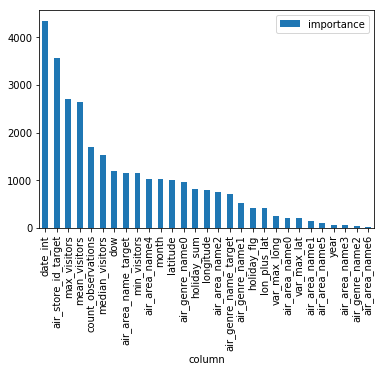

In [215]:
feat_df = pd.DataFrame({
    'importance': lgb.feature_importances_,
    'column': X_trn.columns
})
feat_df.set_index('column', inplace=True)
feat_df.sort_values(by='importance', ascending=False).plot.bar()

全データでfit

In [174]:
lgb.fit(X_all, y_all)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       learning_rate=0.05, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
       n_jobs=-1, num_leaves=60, objective=None, random_state=77,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
       subsample_for_bin=200000, subsample_freq=1)

In [175]:
test['visitors'] = np.expm1(lgb.predict(X_tst))
filename = '../output/180206_lgb_wo_res1'
test[['id', 'visitors']].to_csv(filename+'.csv.gz', index=False, compression='gzip')
test[['id', 'visitors']].to_csv(filename+'.csv', index=False)

In [176]:
import pickle

In [181]:
with open('dataset.pkl', 'wb') as f:
    pickle.dump((
        X_trn, y_trn, X_val, y_val, X_all, y_all, X_tst, val_id
    ), f)